In [1]:
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt

from src import *

plt.rcParams.update({  "font.size": 16,  "font.weight": "bold", })


In [2]:
cropped_data_meanstd_folder = '../ERA_scaling/'
track_data_folder = '../files/'
checkpoints_fodler_era = '../bias_correction_checkpoints_ERA/'

cropped_data_folder = '../files/'
cropped_data_folder_merra = '../files/'
cropped_data_meanstd_folder_merra = '../MERRA_scaling/'
checkpoints_folder_merra = '../bias_correction_checkpoints_MERRA/'


In [3]:

cropped_data_files = sorted(glob.glob(cropped_data_folder + 'ERA*.nc'))
hurdat_track_files = sorted(glob.glob(track_data_folder + '*HURDAT.csv'))
merra_track_files = sorted(glob.glob(track_data_folder + '*ERA.csv'))

files_era = {'cropped_data_files': cropped_data_files, 
         'hurdat_track_files': hurdat_track_files,
         'merra_track_files': merra_track_files}


cropped_data_files_merra = sorted(glob.glob(cropped_data_folder_merra + 'MERRA*.nc'))
merra_track_files_merra = sorted(glob.glob(track_data_folder + '*MERRA.csv'))

files_merra = {'cropped_data_files': cropped_data_files_merra,
         'hurdat_track_files': hurdat_track_files,
         'merra_track_files': merra_track_files_merra}

means_track_files = get_means_stds_from_hurdat_tracks()


In [4]:

hurricane_prefix = '2024C5Beryl_2024063006'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model1_era = UNet(in_channels = 20).to(device)
model2_era = BiasCorrectionModel(in_channels = 20).to(device)
model3_era = VisionGNN(in_channels = 20, out_channels = 2).to(device)

models_era = (model1_era, model2_era, model3_era)
model_paths_era = [f'{checkpoints_fodler_era}/{model.name}_checkpoints.pth' for model in models_era]


model1_merra = UNet(in_channels = 38).to(device)
model2_merra = BiasCorrectionModel(in_channels = 38).to(device)
model3_merra = VisionGNN(in_channels = 38, out_channels = 2).to(device)

models_merra = (model1_merra, model2_merra, model3_merra)
model_paths_merra = [f'{checkpoints_folder_merra}/{model.name}_checkpoints.pth' for model in models_merra]

output_tracks_era = []
output_tracks_merra = []

for model, model_path in zip(models_era, model_paths_era):
    output_tracks_era.append(run_inference(model=model, model_weights=model_path, files=files_era, 
                                                hurricane_prefix=hurricane_prefix, means_track_files=means_track_files, 
                                                cropped_data_meanstd_folder=cropped_data_meanstd_folder))

for model, model_path in zip(models_merra, model_paths_merra):
    output_tracks_merra.append(run_inference(model=model, model_weights=model_path, files=files_merra,
                                                hurricane_prefix=hurricane_prefix, means_track_files=means_track_files,
                                                cropped_data_meanstd_folder=cropped_data_meanstd_folder_merra))

diffs_era = [calculate_mean_differences(output_track) for output_track in output_tracks_era]
diffs_merra = [calculate_mean_differences(output_track) for output_track in output_tracks_merra]

fhours = np.arange(0, output_tracks_era[0]['merra'].shape[0]) * 6


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


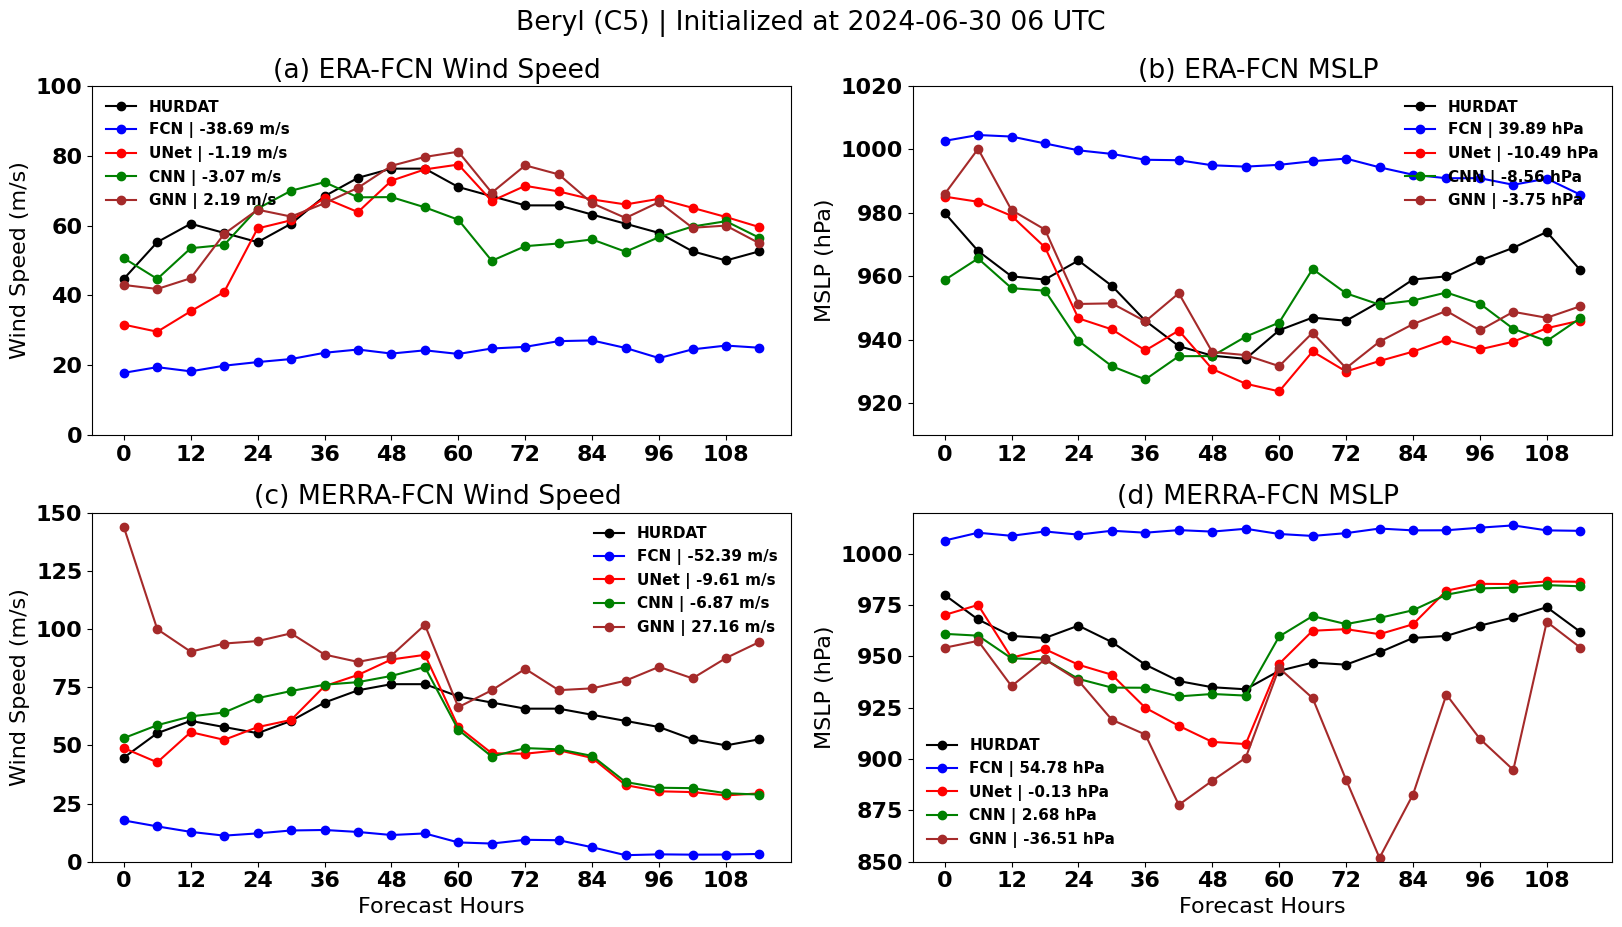

In [5]:
axs = plot_combined_results(output_tracks_era, output_tracks_merra, diffs_era, diffs_merra, fhours, prefix=hurricane_prefix)
axs[0, 0].set_ylim(0, 100)
axs[1, 0].set_ylim(0, 150)

axs[0, 1].set_ylim(910, 1020)
axs[1, 1].set_ylim(850, 1020)

plt.subplots_adjust(top=0.9)
plt.suptitle(get_suptitle(hurricane_prefix))

plt.show()
